# 2023-04-24 Adaptivity

## Last time

* Implicit and explicit methods
* Stiff equations

# Today

* More on stiffness
* PDE examples
* Accuracy
* Adaptivity

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)
heun = RKTable([0 0; 1 0], [.5, .5])
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

function plot_stability(Rz, method; xlim=(-3, 2), ylim=(-1.5, 1.5))
    x = xlim[1]:.02:xlim[2]
    y = ylim[1]:.02:ylim[2]
    plot(title="Stability: $method", aspect_ratio=:equal, xlim=xlim, ylim=ylim)
    heatmap!(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2))
    contour!(x, y, (x, y) -> abs(Rz(x + 1im*y)), color=:black, linewidth=2, levels=[1.])
    plot!(x->0, color=:black, linewidth=1, label=:none)
    plot!([0, 0], [ylim...], color=:black, linewidth=1, label=:none)
end

plot_stability (generic function with 1 method)

# The $\theta$ method


Forward and backward Euler are bookends of the family known as $\theta$ methods.

$$ \tilde u(h) = u(0) + h f\Big(\theta h, \theta\tilde u(h) + (1-\theta)u(0) \Big) $$

which, for linear problems, is solved as

$$ (I - h \theta A) u(h) = \Big(I + h (1-\theta) A \Big) u(0) . $$

$\theta=0$ is explicit Euler, $\theta=1$ is implicit Euler, and $\theta=1/2$ are the midpoint or trapezoid rules (equivalent for linear problems).
The stability function is
$$ R(z) = \frac{1 + (1-\theta)z}{1 - \theta z}. $$

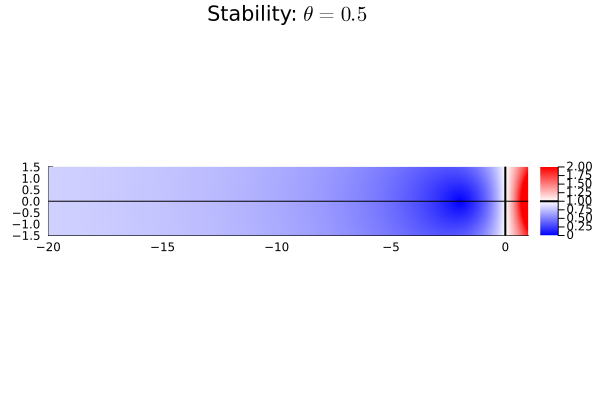

In [106]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = .5
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$", 
    xlim=(-20, 1))

# $\theta$ method for the oscillator

In [3]:
function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_theta_linear (generic function with 1 method)

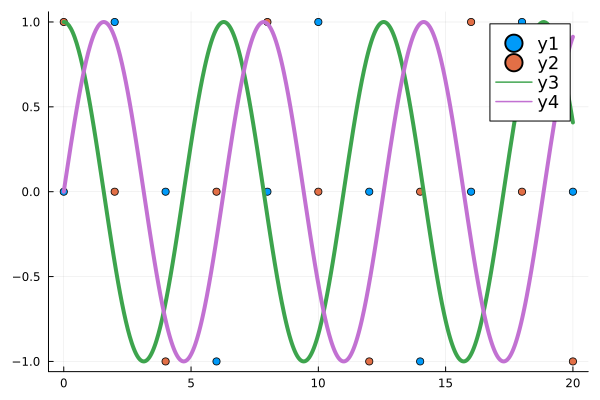

In [114]:
# Test on oscillator
A = [0 1; -1 0]
theta = .5
thist, uhist = ode_theta_linear(A, [0., 1], h=2, theta=theta, tfinal=20)
scatter(thist, uhist')
plot!([cos, sin])

# $\theta$ method for the cosine decay

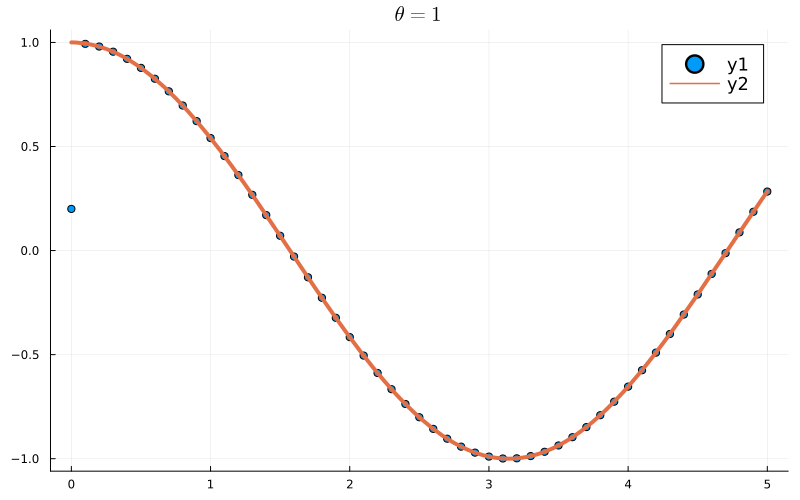

In [129]:
k = 4000
theta = 1
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.1, theta=theta)
scatter(thist, uhist[1,:], title="\$\\theta = $theta\$")
plot!(cos, size=(800, 500))

# Stability classes and the $\theta$ method


## Definition: $A$-stability
A method is $A$-stable if the stability region
$$ \{ z : |R(z)| \le 1 \} $$
contains the entire left half plane $$ \Re[z] \le 0 .$$
This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is indeed physically stable.

## Definition: $L$-stability
A time integrator with stability function $R(z)$ is $L$-stable if
$$ \lim_{z\to\infty} R(z) = 0 .$$
For the $\theta$ method, we have
$$ \lim_{z\to \infty} \frac{1 + (1-\theta)z}{1 - \theta z} = \frac{1-\theta}{\theta} . $$
Evidently only $\theta=1$ is $L$-stable.

# Heat equation as linear ODE

* How do different $\theta \in [0, 1]$ compare in terms of stability?
* Are there artifacts even when the solution is stable?

In [33]:
using SparseArrays

function heat_matrix(n)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.([i-1, i, i+1]))
        append!(vals, [1, -2, 1] ./ dx^2)
    end
    sparse(rows, cols, vals)
end
heat_matrix(8)

8×8 SparseMatrixCSC{Float64, Int64} with 24 stored entries:
 -32.0   16.0     ⋅      ⋅      ⋅      ⋅      ⋅    16.0
  16.0  -32.0   16.0     ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅    16.0  -32.0   16.0     ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅    16.0  -32.0   16.0     ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅    16.0  -32.0   16.0     ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅    16.0  -32.0   16.0     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅    16.0  -32.0   16.0
  16.0     ⋅      ⋅      ⋅      ⋅      ⋅    16.0  -32.0

  0.012178 seconds (8.32 k allocations: 28.983 MiB)


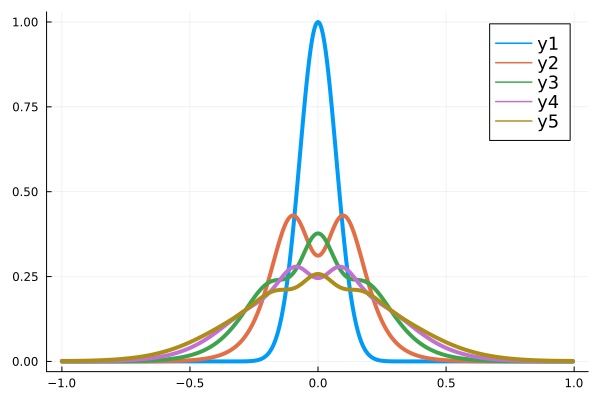

In [135]:
n = 400
A = heat_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-100 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.01, theta=.5, tfinal=1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:5])

# Advection as a linear ODE

In [8]:
function advect_matrix(n; upwind=false)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i])
        if upwind
            append!(cols, wrap.([i-1, i]))
            append!(vals, [1., -1] ./ dx)
        else
            append!(cols, wrap.([i-1, i+1]))
            append!(vals, [1., -1] ./ 2dx)
        end
    end
    sparse(rows, cols, vals)
end
advect_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
  0.0   -1.25    ⋅      ⋅     1.25
  1.25    ⋅    -1.25    ⋅      ⋅ 
   ⋅     1.25    ⋅    -1.25    ⋅ 
   ⋅      ⋅     1.25    ⋅    -1.25
 -1.25    ⋅      ⋅     1.25    ⋅ 

(eigvals(Matrix(A)))[1] = -50.00000000000011 + 0.0im
  0.000373 seconds (965 allocations: 434.438 KiB)


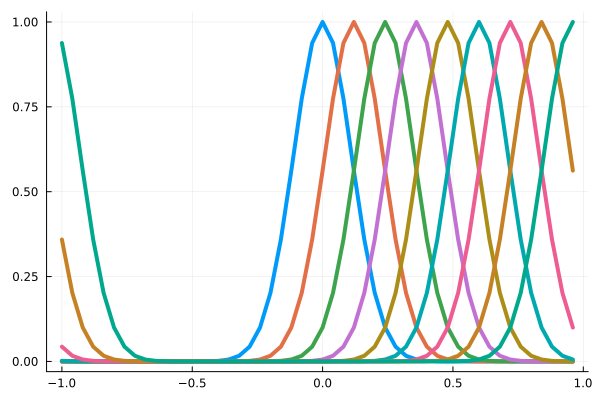

In [154]:
n = 50
A = advect_matrix(n, upwind=true)
@show eigvals(Matrix(A))[1]
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-40 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.04, theta=0, tfinal=1.);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end], legend=:none)

# Spectrum of operators

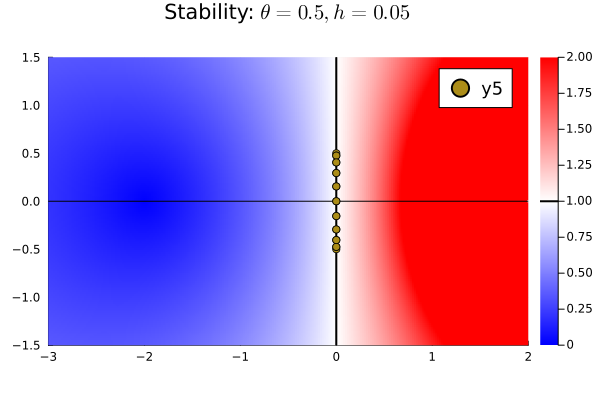

In [160]:
theta = .5
h = .05
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advect_matrix(20, upwind=false)))
scatter!(real(ev), imag(ev))

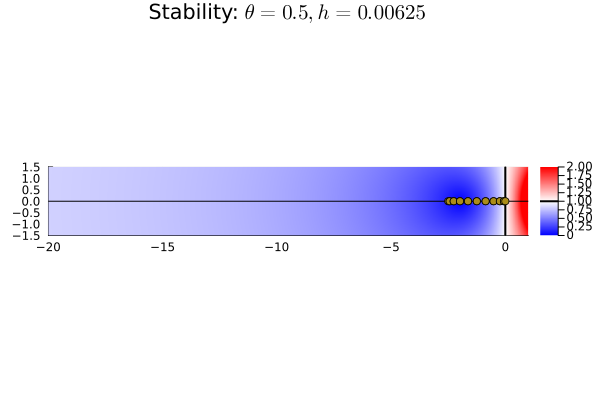

In [165]:
theta=.5
h = .2 / 32
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$", xlim=(-20, 1))
ev = eigvals(Matrix(h*heat_matrix(20)))
scatter!(real(ev), imag(ev), legend=:none)

# Stiffness

> Stiff equations are problems for which explicit methods don’t work. (Hairer and Wanner, 2002)

* “stiff” dates to Curtiss and Hirschfelder (1952)

We'll use the cosine relaxation example $y_t = -k(y - \cos t)$ using the $\theta$ method, varying $k$ and $\theta$.

In [12]:
function ode_error(h; theta=.5, k=10)
    u0 = [.2]
    thist, uhist = ode_theta_linear(-k, u0, forcing=t -> k*cos(t), tfinal=3, h=h, theta=theta)
    T = thist[end]
    u_exact = (u0 .- k^2/(k^2+1)) * exp(-k*T) .+ k*(sin(T) + k*cos(T))/(k^2 + 1)
    uhist[1,end] .- u_exact
end

ode_error (generic function with 1 method)

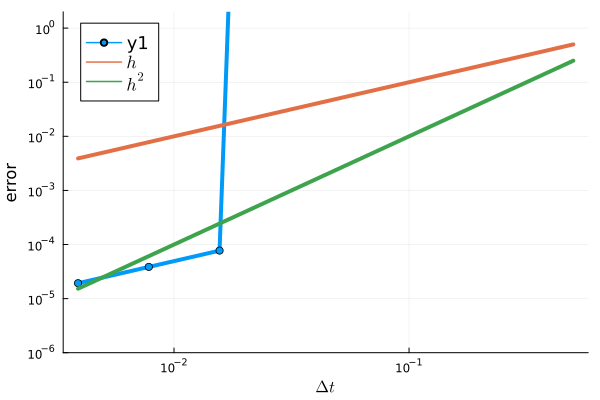

In [180]:
hs = .5 .^ (1:8)
errors = ode_error.(hs, theta=0, k=100)
plot(hs, norm.(errors), marker=:circle, xscale=:log10, yscale=:log10, ylim=(1e-6, 2))
plot!(hs, hs, label="\$h\$", legend=:topleft)
plot!(hs, hs.^2, label="\$h^2\$", ylabel="error", xlabel="\$\\Delta t\$")

# Examples of ODE systems

Stiff problems posess multiple time scales and the fastest scale is "not interesting"

## Stiff

* The ocean

## Non-stiff

* The ocean

# Adaptive time integrators

The [Oregonator](http://www.scholarpedia.org/article/Oregonator) mechanism in chemical kinetics describes an oscillatory chemical system.  It consists of three species with concentrations $\mathbf x = [x_0,x_1,x_2]^T$ (scaled units) and the evolution equations
$$ \mathbf {x'} = \begin{bmatrix} 77.27 \big(x_1 + x_0 (1 - 8.375\cdot 10^{-6} x_0 - x_1) \big) \\
                    \frac{1}{77.27} \big(x_2 - (1 + x_0) x_1 \big) \\
                    0.161 (x_0 - x_2)
                    \end{bmatrix} . $$
We simulate from the initial conditions $\mathbf x_0 = [1, 2, 3]^T$.


![Oregonator time evolution](../img/oregonator.png)

# Our last few sessions

## Topics available
* Answer questions/work problems of your choosing
* Large-scale problems (sparse linear algebra, parallel algorithms)
* Fast Fourier Transform
* Monte Carlo for integration
* Using libraries
* Dive into performance
* Career discussion

## May 1-3 (Mon, Wed): projects
* I'll post a sign-up sheet. If you wish to coordinate with another group looking at a similar topic, we can schedule you together.
* If you prefer to pre-record, do that and share a link on Zulip.
* If you have a group, but it hasn't been mentioned on Zulip, please identify yourself so I can check in.